<h2>Adaptations</h2>

My initial focus for adaptations will be on what was explained as deficiencies to this model in the previous tutorial:
1. **Linear movement**- expand to handle linear movement

2. **Multidimensional tracking**- expand to handle 2D & 3D data

5. **Adapted Dataset**- I will adapt the code to handle linear positions for targets


<h2>Adaptation Steps</h2>

Note- I found that the number of frames in the initial code is very brittle due to the following line:

```python
pyro.sample("is_real",
                dist.Bernoulli(args.expected_num_objects / num_observed),
                obs=is_real.float())
```


Because the expected_num_objects is a set number, and could be more than the num_observed if that occurence not all objects were "emitted" or received a return from a sensor and no spurious objects were received. However, a Bernoulli distribution only takes values between 0 and 1, so I added clipping the values to be within the range [0,1]:



```python
bernoulliRealProbs = self.args.expected_num_objects / num_observed
bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
pyro.sample("is_real",
            dist.Bernoulli(bernoulliRealProbs),
            obs=is_real.float())
```

 

* <h3>Restructuring the code into an object oriented design</h3>

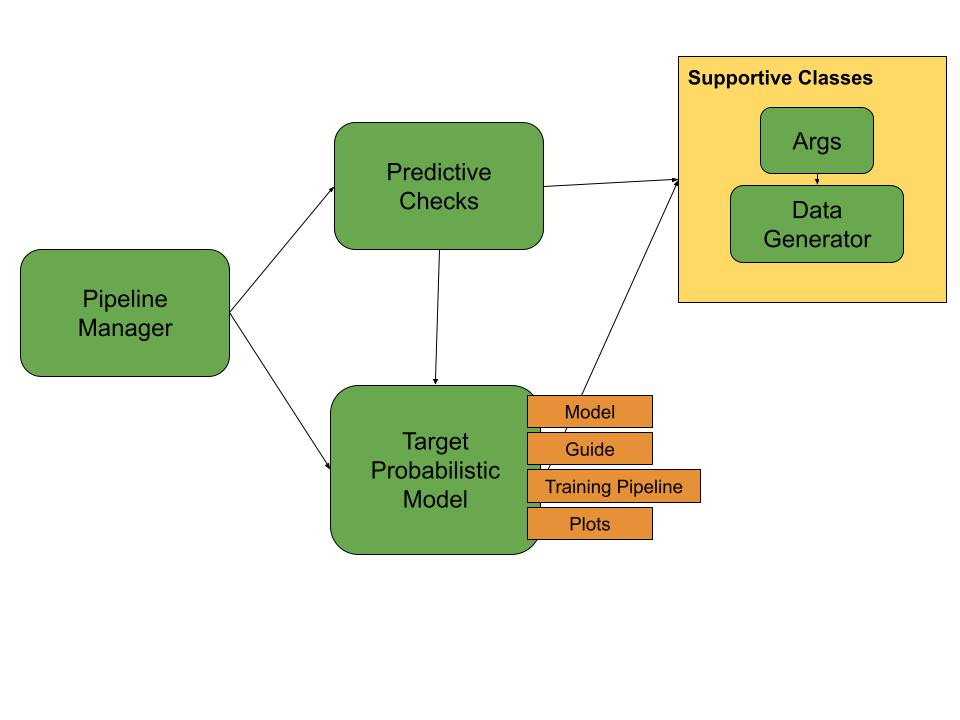

Because the original code was very functionally written, I rewrote the code so it was much more object oriented. 
    
So, first the Pipeline Manager directs and gives options to either run Predictive Checks (which will be explained in the next notebook) or train the model through the Target Probabilistic Model. The Predictive Checks uses the Target Probabilistic Model for each iteration of different parameters to train so that plots can be generated based on the results. Both Predictive Checks and the Target Probilistic Model use the Data Generator and the Args classes to ensure it has the proper preset arguments and data generated for the pipeline. 

First, we import necessary classes

In [4]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
import numpy as np
import enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

assert pyro.__version__.startswith('1.7.0')

The following allows distinguishing which movement type we will be running.

In [5]:
class MovementType(enum.Enum):
    Sinusoidal = 1
    Linear2D = 2
    Linear3D = 3

An Args class allows defining different methods of obtaining necessary args for running the model. 

In [6]:
class Args:
    def __init__(self):
        self.args = self.get_default_args()

    def get_default_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 0.8
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self 
    
    def get_ideal_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 0.
        self.emission_prob = 1.0
        self.emission_noise_scale = 0.
        assert self.max_num_objects >= self.expected_num_objects
        return self     

    def get_prior_predictive_checks_args(self):
        self.num_frames = 5
        self.expected_num_objects = int(dist.Uniform(1, 5).sample())
        self.expected_num_spurious = float(int(dist.Uniform(1,3).sample()))
        self.max_num_objects = int(self.expected_num_objects + self.expected_num_spurious)
        self.emission_prob = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 3.)/4.))) #aiming for between [0.5,1.0]
        self.emission_noise_scale = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 2.)/4.))) #aiming for between [0.0,0.5]
        assert self.max_num_objects >= self.expected_num_objects
        print("Predictive check args. Num objects: ", self.expected_num_objects, " Num spurious: ", self.expected_num_spurious)
        print("Emission prob: ", self.emission_prob, " Noise scale: ", self.emission_noise_scale)
        return self

The Data Generator helps define how data is generated to then send through the model, which I've adapted to handle 2D and 3D as well as sinusoidal movement. So, for each of these this is what is generated when running get_dynamics:

**Sinusoidal (1D):**
dynamics = cos element of time (1 x # frames) concat with sin element of time (1 x # frames)
dimension = 2
shape = 1 x dimension * (# of frames)

**2D:**
dynamics = x position (1 x # frames) concat with y position (1 x # frames)
dimension = 2
shape = 1 x dimension * (# of frames)

**3D:**
dynamics = x position (1 x # frames) concat with y position (1 x # frames) concat with z position (1 x # frames)
dimension = 3
shape = 1 x dimension * (# of frames)

What get_dynamics gets you is one general vector of position information that can be used by generate_data to then perform a matrix multiplication with the variable "states", which is a set of samples from the Normal distribution (# objects x dimension from get_dynamics), so each object has an offset to its position. 

Emitted is sampled for each sensor return (# frames x # objects) based on the emission probability, and is a binary value whether an object was detected at each time frame. 

num_spurious is sampled from a poisson distribution based on the expected number of spurious objects, or number of sensor returns that are not from real objects but are from noise. This is 1 x (# of frames)

Observations, which is ultimately the data we use for model learning. This size is (# frames x max # objects). What this shows is a position and a confidence for all noisy objects that were "emitted" or detected by a sensor at each time frame as well as a position and a confidence for each "spurious" return, or false sensor return. 




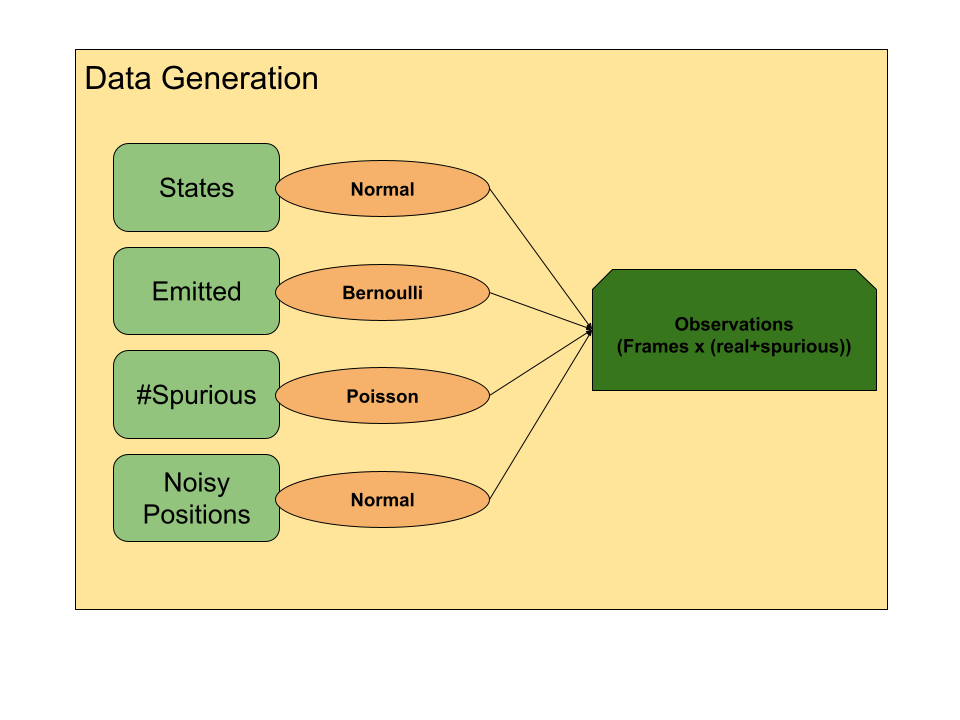

In [7]:
class DataGenerator:
    def __init__(self, movementType):
        print("Initializing DataGenerator with movement type ", movementType)
        self.movementType = movementType
        if self.movementType == MovementType.Sinusoidal:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear2D:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear3D:
            self.numDimensions = 3
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

    def get_dynamics(self, num_frames):
        if self.movementType == MovementType.Sinusoidal:
            time = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([time.cos(), time.sin()], -1)
        elif self.movementType == MovementType.Linear2D:
            x = torch.arange(float(num_frames)) / 4
            y = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([x, y], -1)
        elif self.movementType == MovementType.Linear3D:
            x = torch.arange(float(num_frames)) / 4
            y = torch.arange(float(num_frames)) / 4
            z = torch.arange(float(num_frames)) / 4
            dynamics = torch.stack([x, y, z], -1)
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

        return dynamics

    def generate_data(self, args):
        # Object model.
        num_objects = int(round(args.expected_num_objects))  
        print("Num frames: ", args.num_frames, " with num objects: ", num_objects)
        states = dist.Normal(0., 1.).sample((num_objects, self.numDimensions))

        # Detection model.
        emitted = dist.Bernoulli(args.emission_prob).sample((args.num_frames, num_objects))
        num_spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,))
        max_num_detections = int((num_spurious + emitted.sum(-1)).max())
        observations = torch.zeros(args.num_frames, max_num_detections, 2) # position+confidence
        positions = self.get_dynamics(args.num_frames).mm(states.t())

        noisy_positions = dist.Normal(positions, args.emission_noise_scale).sample()
        for t in range(args.num_frames):
            j = 0
            for i, e in enumerate(emitted[t]):
                if e:
                    observations[t, j, 0] = noisy_positions[t, i]
                    observations[t, j, 1] = 1
                    j += 1
            n = int(num_spurious[t])
            if n:
                observations[t, j:j+n, 0] = dist.Normal(0., 1.).sample((n,))
                observations[t, j:j+n, 1] = 1

        return states, positions, observations, self.numDimensions

I've made a class that can hold the model and the guide, making adaptations where necessary to handle the 2D/3D dimensions and ensuring the values going into the Bernoulli distribution stays between [0,1]. This also handles training, plotting, and getting the results. 
Here is the Plate Diagram for this model:


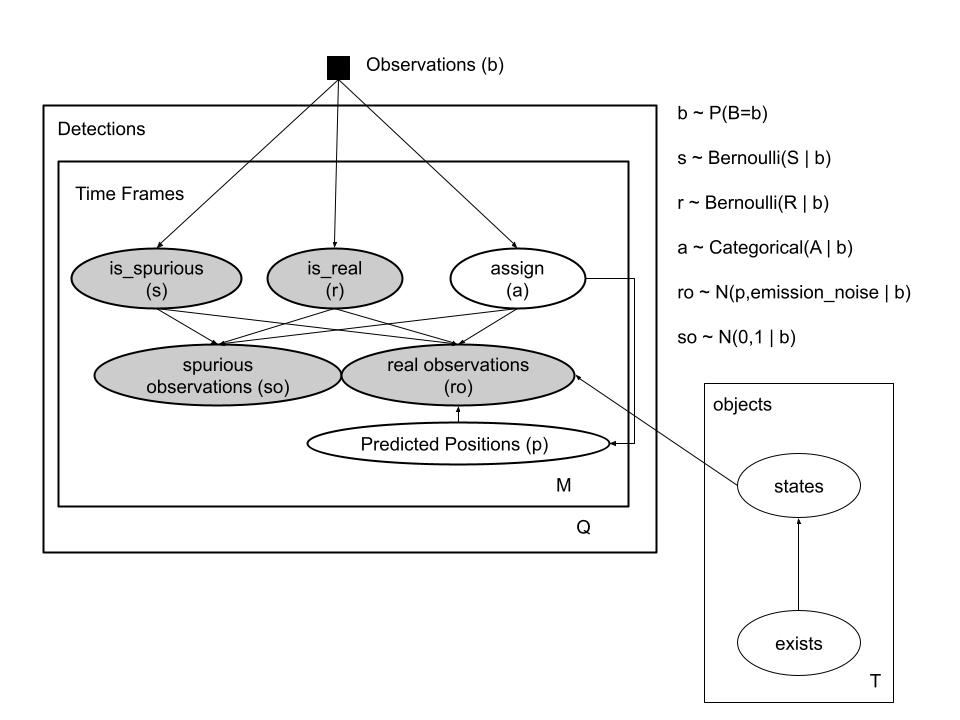

In [8]:
class TargetProbabilisticModel:
    def __init__(self, args, dynamics):
        self.args = args
        self.dynamics = dynamics

    def model(self, args, observations):
        with pyro.plate("objects", self.args.max_num_objects):
            exists = pyro.sample("exists",
                                dist.Bernoulli(self.args.expected_num_objects / self.args.max_num_objects))
            with poutine.mask(mask=exists.bool()):
                states = pyro.sample("states", dist.Normal(0., 1.).expand([self.args.num_dimensions]).to_event(1))
                positions = self.dynamics.mm(states.t())
        with pyro.plate("detections", observations.shape[1]):
            with pyro.plate("time", self.args.num_frames):
                # The combinatorial part of the log prob is approximated to allow independence.
                is_observed = (observations[..., -1] > 0)
                with poutine.mask(mask=is_observed):
                    assign = pyro.sample("assign",
                                        dist.Categorical(torch.ones(self.args.max_num_objects + 1)))
                is_spurious = (assign == self.args.max_num_objects)
                is_real = is_observed & ~is_spurious
                num_observed = is_observed.float().sum(-1, True)

                bernoulliRealProbs = self.args.expected_num_objects / num_observed
                bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
                pyro.sample("is_real",
                            dist.Bernoulli(bernoulliRealProbs),
                            obs=is_real.float())

                bernoulliSpuriousProbs = self.args.expected_num_spurious / num_observed
                bernoulliSpuriousProbs = np.clip(bernoulliSpuriousProbs, 0., 1.)
                pyro.sample("is_spurious",
                            dist.Bernoulli(bernoulliSpuriousProbs),
                            obs=is_spurious.float())

                # The remaining continuous part is exact.
                observed_positions = observations[..., 0]
                with poutine.mask(mask=is_real):
                    bogus_position = positions.new_zeros(self.args.num_frames, 1)
                    augmented_positions = torch.cat([positions, bogus_position], -1)
                    predicted_positions = gather(augmented_positions, assign, -1)
                    pyro.sample("real_observations",
                                dist.Normal(predicted_positions, self.args.emission_noise_scale),
                                obs=observed_positions)
                with poutine.mask(mask=is_spurious):
                    pyro.sample("spurious_observations", dist.Normal(0., 1.),
                                obs=observed_positions)

    def guide(self, args, observations):
        # Initialize states randomly from the prior.
        states_loc = pyro.param("states_loc", lambda: torch.randn(int(self.args.max_num_objects), int(self.args.num_dimensions)))
        states_scale = pyro.param("states_scale",
                                lambda: torch.ones(states_loc.shape) * self.args.emission_noise_scale,
                                constraint=constraints.positive)
        positions = self.dynamics.mm(states_loc.t())

        # Solve soft assignment problem.
        real_dist = dist.Normal(positions.unsqueeze(-2), self.args.emission_noise_scale)
        spurious_dist = dist.Normal(0., 1.)
        is_observed = (observations[..., -1] > 0)
        observed_positions = observations[..., 0].unsqueeze(-1)
        assign_logits = (real_dist.log_prob(observed_positions) -
                        spurious_dist.log_prob(observed_positions) +
                        math.log(self.args.expected_num_objects * self.args.emission_prob /
                                self.args.expected_num_spurious))
        assign_logits[~is_observed] = -float('inf')
        exists_logits = torch.empty(self.args.max_num_objects).fill_(
            math.log(self.args.max_num_objects / self.args.expected_num_objects))
        assignment = MarginalAssignmentPersistent(exists_logits, assign_logits)

        with pyro.plate("objects", self.args.max_num_objects):
            exists = pyro.sample("exists", assignment.exists_dist, infer={"enumerate": "parallel"})
            with poutine.mask(mask=exists.bool()):
                pyro.sample("states", dist.Normal(states_loc, states_scale).to_event(1))
        with pyro.plate("detections", observations.shape[1]):
            with poutine.mask(mask=is_observed):
                with pyro.plate("time", self.args.num_frames):
                    assign = pyro.sample("assign", assignment.assign_dist, infer={"enumerate": "parallel"})

        return assignment

    def train(self, true_states, true_positions, observations, visualize = False):
        pyro.set_rng_seed(0)
        true_num_objects = len(true_states)
        max_num_detections = observations.shape[1]
        print("generated {:d} detections from {:d} objects".format(
            (observations[..., -1] > 0).long().sum(), true_num_objects))

        pyro.set_rng_seed(1)
        pyro.clear_param_store()
        self.plot_solution( observations, true_positions, '(before training)')

        infer = SVI(self.model, self.guide, Adam({"lr": 0.01}), TraceEnum_ELBO(max_plate_nesting=2))
        losses = []
        for epoch in range(101):
            loss = infer.step(self.args, observations)
            if epoch % 10 == 0:
                print("epoch {: >4d} loss = {}".format(epoch, loss))
            if visualize:
                losses.append(loss)
        if visualize:
            pyplot.plot(losses)
            self.plot_solution(observations, true_positions, '(after training)')

    def get_predicted_positions(self):
        states_loc = pyro.param("states_loc")
        return self.dynamics.mm(states_loc.t())

    def plot_solution(self, observations, true_positions, message=''):
        assignment = self.guide(self.args, observations)
        states_loc = pyro.param("states_loc")
        positions = self.dynamics.mm(states_loc.t())
        pyplot.figure(figsize=(12,6)).patch.set_color('white')
        pyplot.plot(true_positions.numpy(), 'k--')
        is_observed = (observations[..., -1] > 0)
        pos = observations[..., 0]
        time = torch.arange(float(self.args.num_frames)).unsqueeze(-1).expand_as(pos)
        pyplot.scatter(time[is_observed].view(-1).numpy(),
                    pos[is_observed].view(-1).numpy(), color='k', marker='+',
                    label='observation')
        for i in range(self.args.max_num_objects):
            p_exist = assignment.exists_dist.probs[i].item()
            position = positions[:, i].detach().numpy()
            pyplot.plot(position, alpha=p_exist, color='C0')
        pyplot.title('Truth, observations, and predicted tracks ' + message)
        pyplot.plot([], 'k--', label='truth')
        pyplot.plot([], color='C0', label='prediction')
        pyplot.legend(loc='best')
        pyplot.xlabel('time step')
        pyplot.ylabel('position')
        pyplot.tight_layout()
        pyplot.show()

My Pipeline Manager handles which steps should be taken to run the code, with Linear2D as the default movement type. 

In [12]:
class PipelineManager:
    def __init__(self, movementType=MovementType.Linear2D):
        self.argManager = Args()
        self.dataGenerator = DataGenerator(movementType)        

    def trainAndPredict(self, ideal=True):
        if ideal:
            args = self.argManager.get_ideal_args()
        else:
            args = self.argManager.get_default_args()
            
        dynamics = self.dataGenerator.get_dynamics(args.num_frames)

        true_states, true_positions, observations, num_dimensions = self.dataGenerator.generate_data(args)
        args.num_dimensions = int(num_dimensions)

        targetProbabilisticModel = TargetProbabilisticModel(args, dynamics)
        targetProbabilisticModel.train(true_states, true_positions, observations, True)
        targetProbabilisticModel.plot_solution(observations, true_positions)


I can then run the code for each movement type. First I run an ideal scenario, then I run with the default args, including more noise. 

Initializing DataGenerator with movement type  MovementType.Sinusoidal
Num frames:  5  with num objects:  3
generated 18 detections from 3 objects


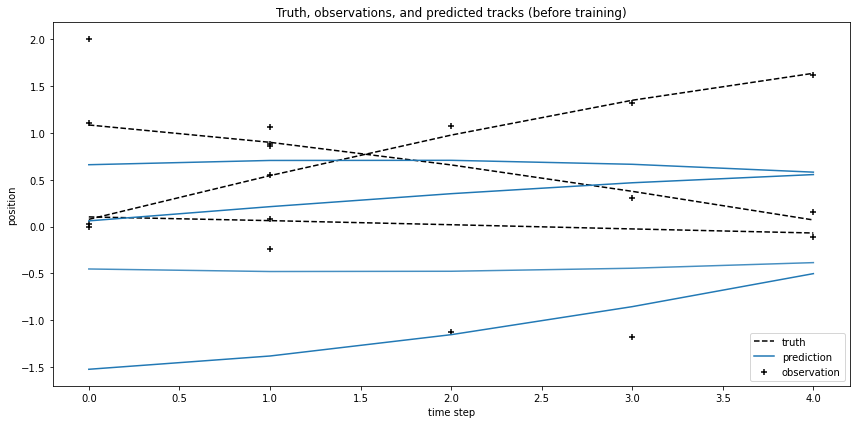

epoch    0 loss = 360.6341247558594
epoch   10 loss = 313.5415344238281
epoch   20 loss = 299.6664733886719
epoch   30 loss = 281.1099548339844
epoch   40 loss = 281.95111083984375
epoch   50 loss = 277.2361755371094
epoch   60 loss = 278.89849853515625
epoch   70 loss = 277.31304931640625
epoch   80 loss = 272.338623046875
epoch   90 loss = 276.61810302734375
epoch  100 loss = 272.3877258300781


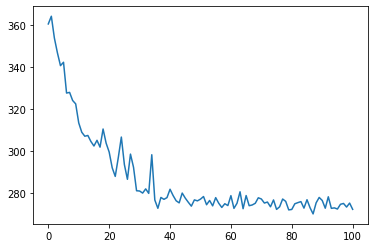

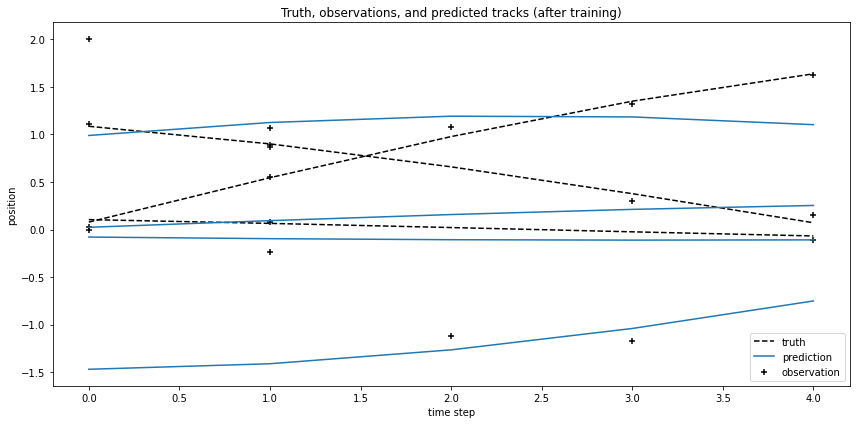

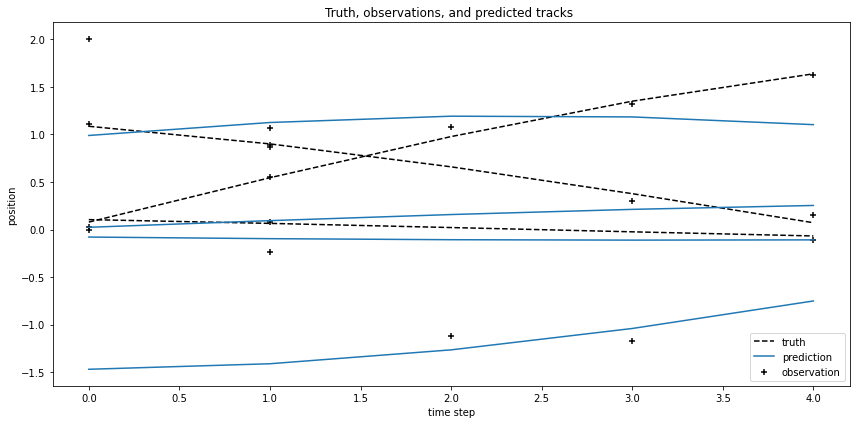

Initializing DataGenerator with movement type  MovementType.Linear2D
Num frames:  5  with num objects:  3
generated 17 detections from 3 objects


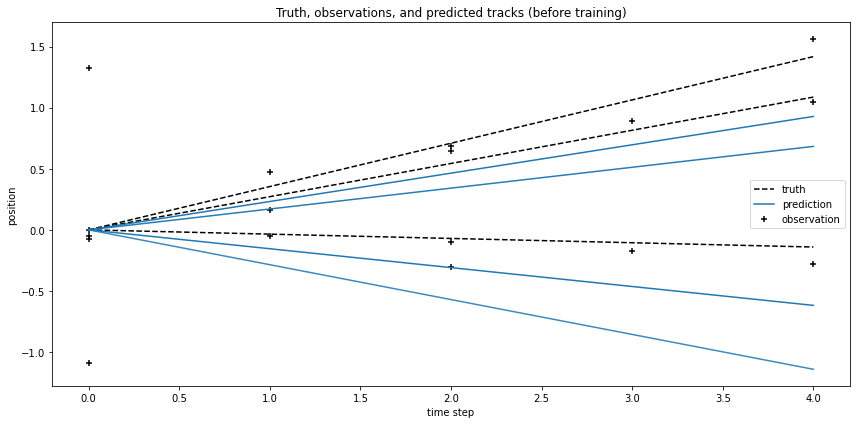

epoch    0 loss = 244.74819946289062
epoch   10 loss = 207.90692138671875
epoch   20 loss = 189.21661376953125
epoch   30 loss = 170.273681640625
epoch   40 loss = 174.5336456298828
epoch   50 loss = 172.968505859375
epoch   60 loss = 169.2130126953125
epoch   70 loss = 175.35020446777344
epoch   80 loss = 174.87335205078125
epoch   90 loss = 171.81021118164062
epoch  100 loss = 173.33123779296875


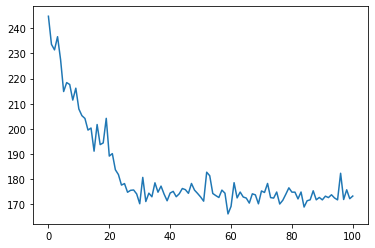

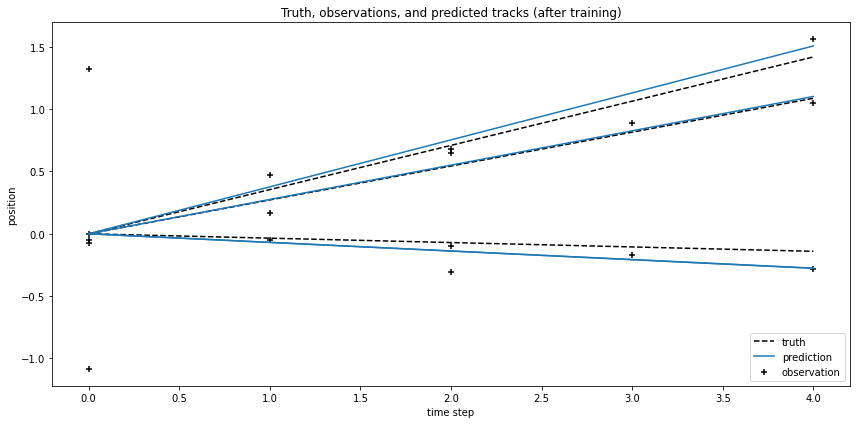

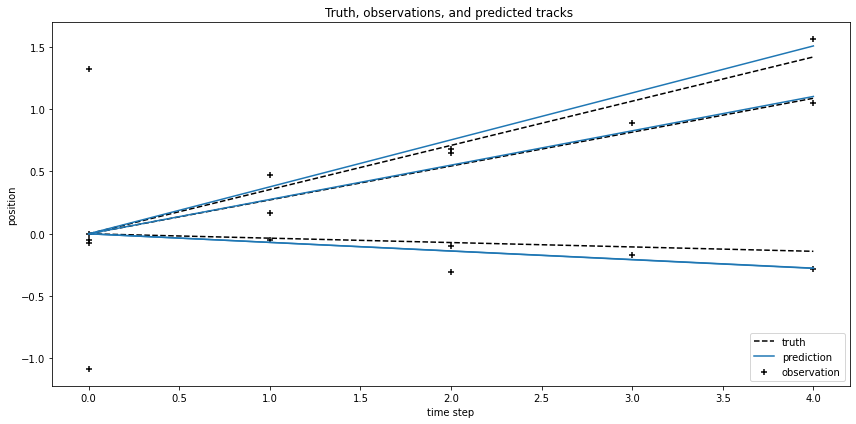

Initializing DataGenerator with movement type  MovementType.Linear3D
Num frames:  5  with num objects:  3
generated 14 detections from 3 objects


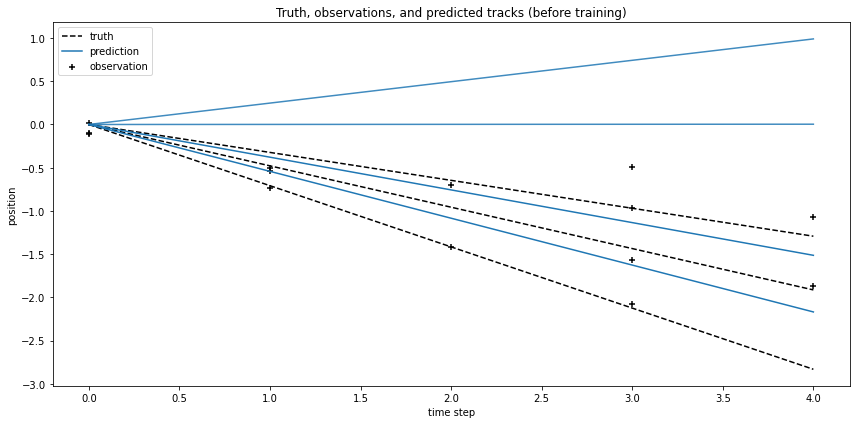

epoch    0 loss = 223.27117919921875
epoch   10 loss = 215.70828247070312
epoch   20 loss = 211.00038146972656
epoch   30 loss = 196.14498901367188
epoch   40 loss = 199.7469482421875
epoch   50 loss = 195.76808166503906
epoch   60 loss = 196.79168701171875
epoch   70 loss = 198.2530059814453
epoch   80 loss = 199.5159912109375
epoch   90 loss = 195.35006713867188
epoch  100 loss = 192.33425903320312


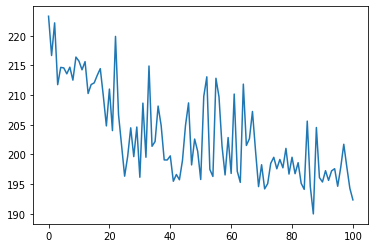

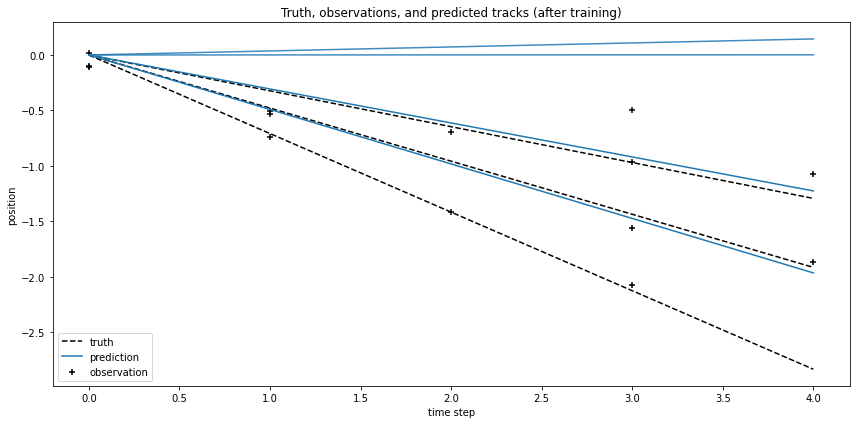

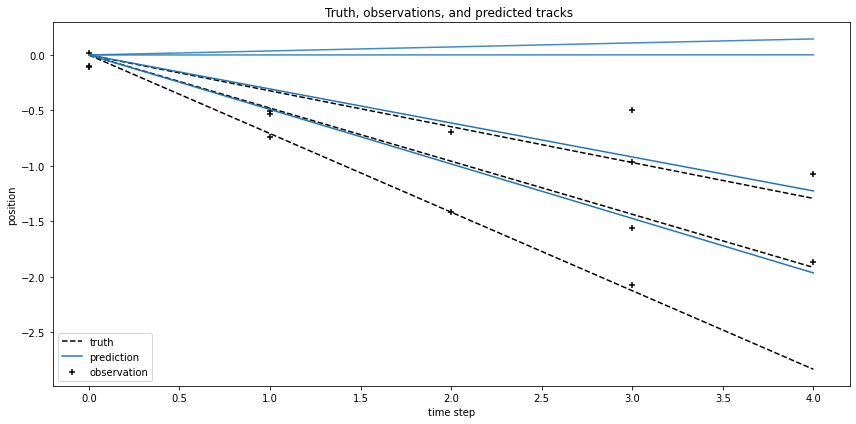

In [11]:
pipelineManager = PipelineManager(MovementType.Sinusoidal)
pipelineManager.trainAndPredict()
pipelineManager = PipelineManager(MovementType.Linear2D)
pipelineManager.trainAndPredict()
pipelineManager = PipelineManager(MovementType.Linear3D)
pipelineManager.trainAndPredict()

Initializing DataGenerator with movement type  MovementType.Sinusoidal
Num frames:  5  with num objects:  3
generated 13 detections from 3 objects


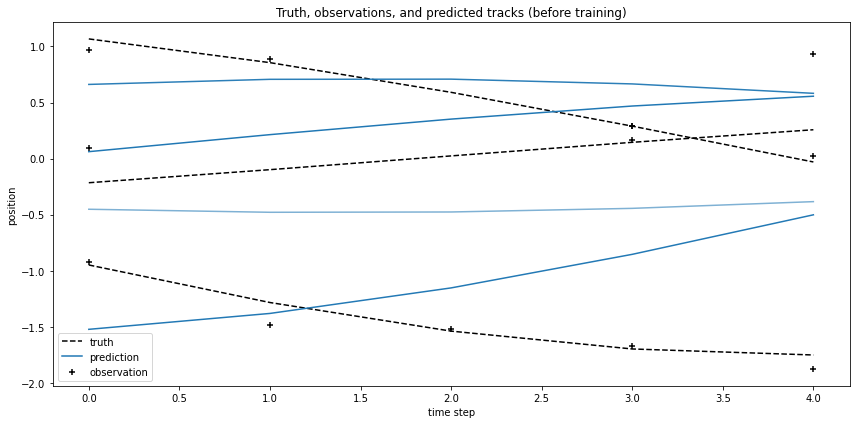

epoch    0 loss = 283.68414306640625
epoch   10 loss = 244.84942626953125
epoch   20 loss = 225.27403259277344
epoch   30 loss = 221.30316162109375
epoch   40 loss = 223.37718200683594
epoch   50 loss = 223.34811401367188
epoch   60 loss = 218.93606567382812
epoch   70 loss = 222.28286743164062
epoch   80 loss = 221.5536346435547
epoch   90 loss = 227.29954528808594
epoch  100 loss = 222.28529357910156


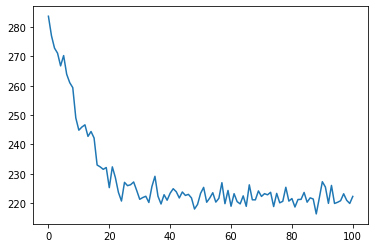

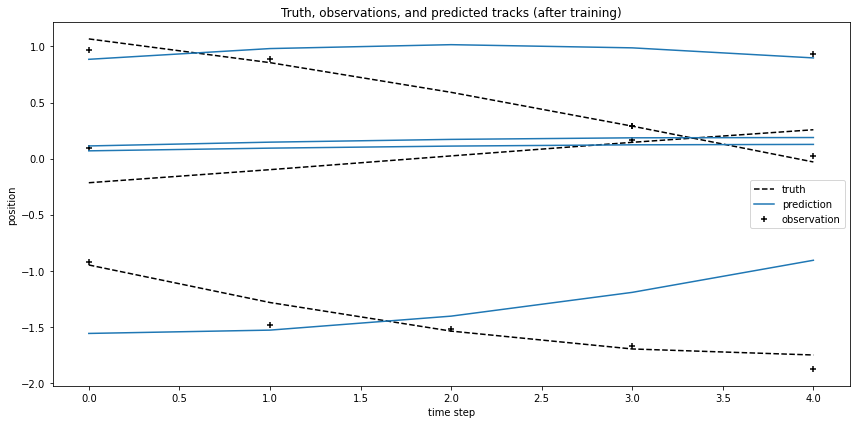

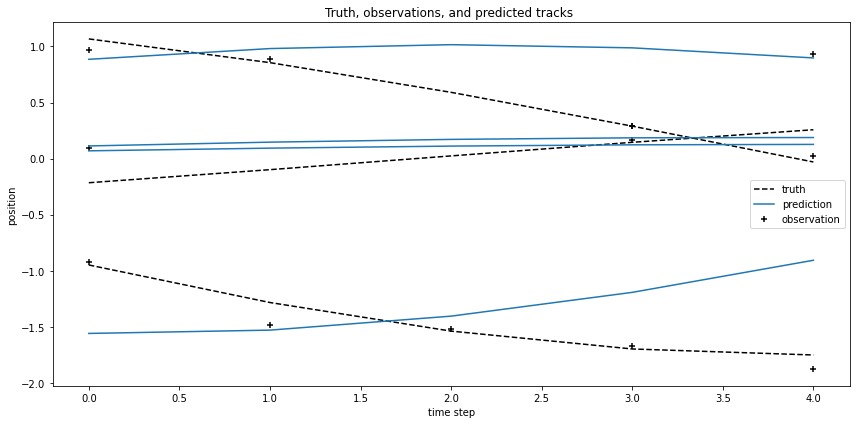

Initializing DataGenerator with movement type  MovementType.Linear2D
Num frames:  5  with num objects:  3
generated 17 detections from 3 objects


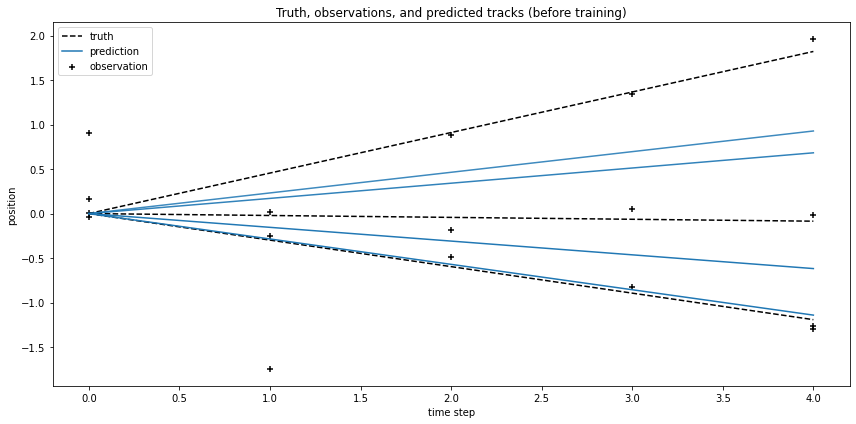

epoch    0 loss = 186.70855712890625
epoch   10 loss = 180.451171875
epoch   20 loss = 165.53024291992188
epoch   30 loss = 159.3594970703125
epoch   40 loss = 161.22731018066406
epoch   50 loss = 160.31361389160156
epoch   60 loss = 157.10874938964844
epoch   70 loss = 160.38815307617188
epoch   80 loss = 164.30174255371094
epoch   90 loss = 162.29336547851562
epoch  100 loss = 161.89608764648438


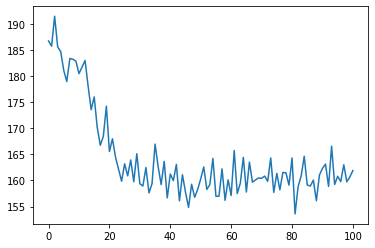

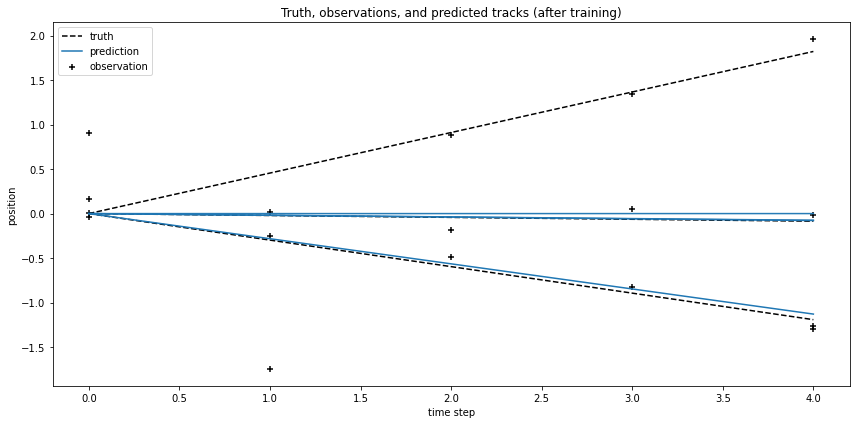

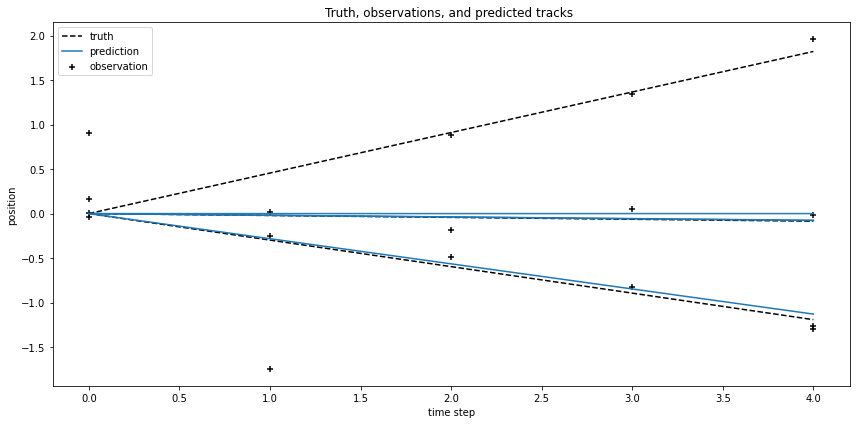

Initializing DataGenerator with movement type  MovementType.Linear3D
Num frames:  5  with num objects:  3
generated 16 detections from 3 objects


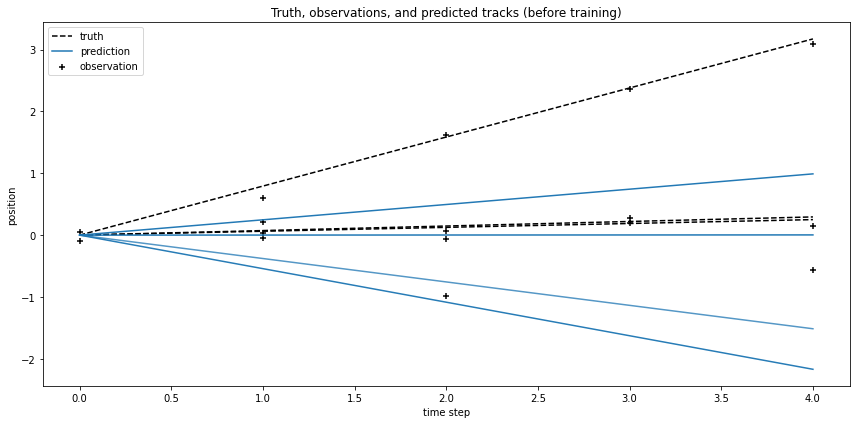

epoch    0 loss = 216.97923278808594
epoch   10 loss = 202.03245544433594
epoch   20 loss = 187.47329711914062
epoch   30 loss = 177.99388122558594
epoch   40 loss = 183.95069885253906
epoch   50 loss = 184.97438049316406
epoch   60 loss = 183.00291442871094
epoch   70 loss = 184.85491943359375
epoch   80 loss = 183.87448120117188
epoch   90 loss = 182.4552001953125
epoch  100 loss = 195.19638061523438


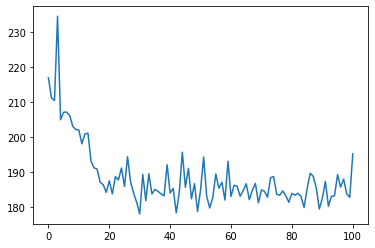

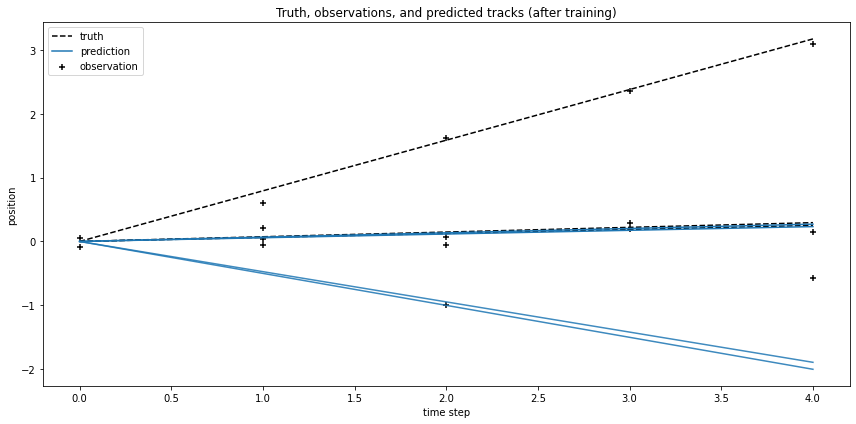

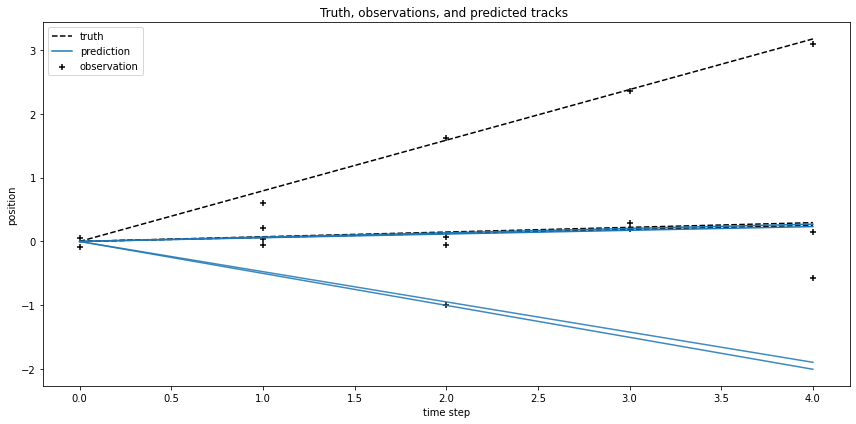

In [13]:
#running with added noise
pipelineManager = PipelineManager(MovementType.Sinusoidal)
pipelineManager.trainAndPredict(False)
pipelineManager = PipelineManager(MovementType.Linear2D)
pipelineManager.trainAndPredict(False)
pipelineManager = PipelineManager(MovementType.Linear3D)
pipelineManager.trainAndPredict(False)